We will show the main RePlay functionality and compare performance of RePlay models on well-known MovieLens dataset. For simplicity we consider here only the variou bandit algorithms with context. The list of considered strategies for comparison:

1) Linear UCB

2) Linear Thompson Sampling

3) Logistic Thompson Sampling

### Dataset

We will compare RePlay models on MovieLens 1m.

### Dataset preprocessing:

Ratings greater than or equal to 3 are considered as positive interactions.

### Data split

Dataset is split by date so that 20% of the last interactions as are placed in the test part. Cold items and users are dropped.

### Predict:
We will predict top-10 most relevant films for each user.

### Metrics

Quality metrics used: ndcg@k, hitrate@k, map@k, mrr@k for k = 1, 5, 10 Additional metrics used: coverage@k and surprisal@k.


In [ ]:
! pip install rs-datasets

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%config Completer.use_jedi = False

In [4]:
import warnings
from optuna.exceptions import ExperimentalWarning
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=ExperimentalWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

In [5]:
import logging
import time
import pandas as pd
import numpy as np

from pyspark.sql import functions as sf, types as st
from pyspark.sql.types import IntegerType

from replay.experimental.preprocessing.data_preparator import Indexer, DataPreparator
from replay.metrics import Coverage, HitRate, MRR, MAP, NDCG, Surprisal, Experiment
from replay.experimental.models import (
    NeuralTS
)


from replay.utils.session_handler import State
from replay.splitters import TimeSplitter
from replay.utils.spark_utils import get_log_info
from rs_datasets import MovieLens

In [ ]:
spark = State().session
spark

In [7]:
spark.sparkContext.setLogLevel('ERROR')

In [8]:
logger = logging.getLogger("replay")

In [9]:
K = 10
K_list_metrics = [1, 5, 10]
BUDGET = 20
BUDGET_NN = 10
SEED = 12345

## Preprocessing 

### Data loading

In [10]:
data = MovieLens("1m")
data.info()

ratings


,user_id,item_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968



users


,user_id,gender,age,occupation,zip_code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117



items


,item_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance


In [11]:
data.ratings

,user_id,item_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291
...,...,...,...,...
1000204,6040,1091,1,956716541
1000205,6040,1094,5,956704887
1000206,6040,562,5,956704746
1000207,6040,1096,4,956715648


In [12]:
preparator = DataPreparator()

In [13]:
%%time
log = preparator.transform(columns_mapping={'user_id': 'user_id',
                                      'item_id': 'item_id',
                                      'relevance': 'rating',
                                      'timestamp': 'timestamp'
                                     }, 
                           data=data.ratings)

21-Oct-24 09:47:34, replay, INFO: Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.


CPU times: user 235 ms, sys: 31.7 ms, total: 267 ms
Wall time: 17.8 s


In [14]:
# will consider ratings >= 3 as positive feedback. A positive feedback is treated with relevance = 1
only_positives_log = log.filter(sf.col('relevance') >= 3).withColumn('relevance', sf.lit(1))
only_positives_log.count()

836478

### Indexing 

In [15]:
indexer = Indexer(user_col='user_id', item_col='item_id')

In [16]:
%%time
indexer.fit(users=log.select('user_id'),
           items=log.select('item_id'))

CPU times: user 30 ms, sys: 10.8 ms, total: 40.8 ms
Wall time: 30.3 s


In [17]:
%%time
log_replay = indexer.transform(df=only_positives_log)
log_replay.show(2)
log_replay.count()

+--------+--------+---------+-------------------+
|user_idx|item_idx|relevance|          timestamp|
+--------+--------+---------+-------------------+
|    4131|      43|        1|2001-01-01 01:12:40|
|    4131|     585|        1|2001-01-01 01:35:09|
+--------+--------+---------+-------------------+
only showing top 2 rows

CPU times: user 46.4 ms, sys: 9.75 ms, total: 56.1 ms
Wall time: 1min 12s


836478

### Data split

In [18]:
# train/test split 
train_spl = TimeSplitter(
    time_threshold=0.2,
    drop_cold_items=True,
    drop_cold_users=True,
    query_column="user_idx",
    item_column="item_idx",
)

train, test = train_spl.split(log_replay)
print('train info:\n', get_log_info(train))
print('test info:\n', get_log_info(test))

train info:
 total lines: 669181, total users: 5397, total items: 3569


test info:
 total lines: 86542, total users: 1139, total items: 3279


In [19]:
train.is_cached

False

In [20]:
# train/test split for hyperparameters selection
opt_train, opt_val = train_spl.split(train)
opt_train.count(), opt_val.count()

(535343, 24241)

In [21]:
opt_train.is_cached

False

In [22]:
# negative feedback will be used for Wilson and UCB models
only_negatives_log = indexer.transform(df=log.filter(sf.col('relevance') < 3).withColumn('relevance', sf.lit(0.)))
test_start = test.agg(sf.min('timestamp')).collect()[0][0]

# train with both positive and negative feedback
pos_neg_train=(train
              .withColumn('relevance', sf.lit(1.))
              .union(only_negatives_log.filter(sf.col('timestamp') < test_start))
             )
pos_neg_train.cache()
pos_neg_train.count()

798993

In [23]:
pos_neg_train.is_cached

True

In [24]:
pos_neg_train.groupBy('relevance').count().show()

+---------+------+
|relevance| count|
+---------+------+
|      1.0|669181|
|      0.0|129812|
+---------+------+



### Item features 

In [25]:
item_features_original = preparator.transform(columns_mapping={'item_id': 'item_id'}, 
                           data=data.items)
item_features = indexer.transform(df=item_features_original)
item_features.show(2)
#different item features

from pyspark.sql.functions import max,min
item_features.select(max(item_features.item_idx)).show()
item_features.select(min(item_features.item_idx)).show()
#just to check that the indexing is dense between 0 and 3882
item_features.count()

21-Oct-24 09:59:18, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.


+--------+----------------+--------------------+
|item_idx|           title|              genres|
+--------+----------------+--------------------+
|      29|Toy Story (1995)|Animation|Childre...|
|     393|  Jumanji (1995)|Adventure|Childre...|
+--------+----------------+--------------------+
only showing top 2 rows

+-------------+
|max(item_idx)|
+-------------+
|         3882|
+-------------+

+-------------+
|min(item_idx)|
+-------------+
|            0|
+-------------+



3883

In [26]:
year = item_features.withColumn('year', sf.substring(sf.col('title'), -5, 4).astype(st.IntegerType())).select('item_idx', 'year')
year.show(2)

+--------+----+
|item_idx|year|
+--------+----+
|      29|1995|
|     393|1995|
+--------+----+
only showing top 2 rows



In [27]:
genres = (
    item_features.select(
        "item_idx",
        sf.split("genres", "\|").alias("genres")
    )
)

In [28]:
genres_list = (
    genres.select(sf.explode("genres").alias("genre"))
    .distinct().filter('genre <> "(no genres listed)"')
    .toPandas()["genre"].tolist()
)

In [29]:
item_features = genres
for genre in genres_list:
    item_features = item_features.withColumn(
        genre,
        sf.array_contains(sf.col("genres"), genre).astype(IntegerType())
    )
item_features = item_features.drop("genres").cache()
item_features.count()
item_features = item_features.join(year, on='item_idx', how='inner')

In [30]:
item_features = item_features.withColumnRenamed("Children's","Children")
item_features = item_features.toPandas()

In [31]:
item_features.columns

Index(['item_idx', 'Documentary', 'Adventure', 'Animation', 'Comedy',
       'Thriller', 'Sci-Fi', 'Musical', 'Horror', 'Action', 'Fantasy', 'War',
       'Mystery', 'Children', 'Drama', 'Crime', 'Romance', 'Film-Noir',
       'Western', 'year'],
      dtype='object')

### Users features

In [32]:
data.users.head()

,user_id,gender,age,occupation,zip_code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [33]:
#same preprocessing for users as was done in 2.4.1.
user_features_original = preparator.transform(columns_mapping={'user_id': 'user_id'}, 
                           data=data.users)
user_features = indexer.transform(df=user_features_original)
#switch for a while into pandas
user_features = user_features.toPandas()
user_features.head(2)

21-Oct-24 09:59:21, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.


,user_idx,gender,age,occupation,zip_code
0,4131,F,1,10,48067
1,2364,M,56,16,70072


In [34]:
from pyspark.sql.functions import mean, stddev
user_train_mean = pos_neg_train.groupBy('user_idx').mean('relevance').withColumnRenamed('avg(relevance)','user_mean_rel').toPandas()
user_train_count = pos_neg_train.groupBy('user_idx').count().withColumnRenamed('count','user_count_rel').toPandas()
user_train_std = pos_neg_train.groupBy('user_idx').agg({'relevance': 'stddev'}).withColumnRenamed('stddev(relevance)','user_std_rel').toPandas()
user_train_median = pd.DataFrame(pos_neg_train.toPandas().groupby('user_idx', as_index = False)['relevance'].agg('median')).rename(columns={'relevance': 'user_median_rel'})
user_train_kurt = pd.DataFrame(pos_neg_train.toPandas().groupby('user_idx', as_index = False)['relevance'].apply(pd.DataFrame.kurt)).rename(columns={'relevance': 'user_kurt_rel'})
user_train_skew = pd.DataFrame(pos_neg_train.toPandas().groupby('user_idx', as_index = False)['relevance'].apply(pd.DataFrame.skew)).rename(columns={'relevance': 'user_skew_rel'})

item_train_mean = pos_neg_train.groupBy('item_idx').mean('relevance').withColumnRenamed('avg(relevance)','item_mean_rel').toPandas()
item_train_count = pos_neg_train.groupBy('item_idx').count().withColumnRenamed('count','item_count_rel').toPandas()
item_train_std = pos_neg_train.groupBy('item_idx').agg({'relevance': 'stddev'}).withColumnRenamed('stddev(relevance)','item_std_rel').toPandas()
item_train_median = pd.DataFrame(pos_neg_train.toPandas().groupby('item_idx', as_index = False)['relevance'].agg('median')).rename(columns={'relevance': 'item_median_rel'})
item_train_kurt = pd.DataFrame(pos_neg_train.toPandas().groupby('item_idx', as_index = False)['relevance'].apply(pd.DataFrame.kurt)).rename(columns={'relevance': 'item_kurt_rel'})
item_train_skew = pd.DataFrame(pos_neg_train.toPandas().groupby('item_idx', as_index = False)['relevance'].apply(pd.DataFrame.skew)).rename(columns={'relevance': 'item_skew_rel'})

full_mean = pos_neg_train.select(mean('relevance')).toPandas().values.squeeze()
full_count = 0
full_std = pos_neg_train.agg({'relevance': 'stddev'}).toPandas().values.squeeze()
full_median = pos_neg_train.toPandas()['relevance'].median().squeeze()
full_kurt = pos_neg_train.toPandas()['relevance'].kurt().squeeze()
full_skew = pos_neg_train.toPandas()['relevance'].skew().squeeze()

In [35]:
user_train_sum = pos_neg_train.groupBy('user_idx').sum('relevance').withColumnRenamed('sum(relevance)','user_sum_rel').toPandas()
item_train_sum = pos_neg_train.groupBy('item_idx').sum('relevance').withColumnRenamed('sum(relevance)','item_sum_rel').toPandas()

In [36]:
item_train_sum.head(10)

,item_idx,item_sum_rel
0,660,349.0
1,783,312.0
2,619,189.0
3,612,399.0
4,263,581.0
5,18,1864.0
6,1229,180.0
7,186,822.0
8,471,437.0
9,38,1432.0


In [37]:
user_all_true = pd.DataFrame({'user_idx': user_train_sum['user_idx'].values , 
                              'user_all_true': (user_train_sum['user_sum_rel'] == user_train_count['user_count_rel'].values).astype(int)})
item_all_true = pd.DataFrame({'item_idx': item_train_sum['item_idx'].values , 
                              'item_all_true': (item_train_sum['item_sum_rel'] == item_train_count['item_count_rel'].values).astype(int)})

In [38]:
pop_item = pd.DataFrame({'item_idx': item_train_mean['item_idx'].values , 
                              'item_is_pop': (item_train_mean['item_mean_rel'] > 0.9).astype(int)})

In [39]:
from sklearn.preprocessing import OneHotEncoder
print("max ocupation index: ", user_features['occupation'].max())
print("min ocupation index: ", user_features['occupation'].min())
count_diff_zips = user_features['zip_code'].unique().size
print("different zip codes: ", count_diff_zips) 
users_pd = user_features
users_pd['zip_code'] = users_pd['zip_code'].apply(lambda x: x[0])

#binarize age variable
bins = [0, 20, 30, 40, 50, 60, np.inf]
names = ['<20', '20-29', '30-39','40-49', '51-60', '60+']

users_pd['agegroup'] = pd.cut(users_pd['age'], bins, labels=names)
# users_pd = users_pd.drop(["age"], axis = 1)
# users_pd.head()

# #binarize following https://github.com/kfoofw/bandit_simulations/tree/master
# columnsToEncode = ["agegroup","gender","occupation"]
# myEncoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
# myEncoder.fit(users_pd[columnsToEncode])

# users_pd = pd.concat([users_pd.drop(columnsToEncode, 1),
#                            pd.DataFrame(myEncoder.transform(users_pd[columnsToEncode]), 
#                                         columns = myEncoder.get_feature_names_out(columnsToEncode))], axis=1).reindex()
users_pd['gender_occupation'] = users_pd['gender'] + '_' + users_pd['occupation'].astype(str)
users_pd.head()

max ocupation index:  20
min ocupation index:  0
different zip codes:  3439


,user_idx,gender,age,occupation,zip_code,agegroup,gender_occupation
0,4131,F,1,10,4,<20,F_10
1,2364,M,56,16,7,51-60,M_16
2,4217,M,25,15,5,20-29,M_15
3,5916,M,45,7,0,40-49,M_7
4,1603,M,25,20,5,20-29,M_20


In [40]:
#stats
users_pd = users_pd.merge(user_train_mean, on='user_idx', how='left')
users_pd['user_mean_rel'].fillna(full_mean, inplace = True)

users_pd = users_pd.merge(user_train_count, on='user_idx', how='left')
users_pd['user_count_rel'].fillna(full_count, inplace = True)

users_pd = users_pd.merge(user_train_std, on='user_idx', how='left')
users_pd['user_std_rel'].fillna(full_std, inplace = True)

users_pd = users_pd.merge(user_train_median, on='user_idx', how='left')
users_pd['user_median_rel'].fillna(full_median, inplace = True)

users_pd = users_pd.merge(user_train_kurt, on='user_idx', how='left')
users_pd['user_kurt_rel'].fillna(full_kurt, inplace = True)

users_pd = users_pd.merge(user_train_skew, on='user_idx', how='left')
users_pd['user_skew_rel'].fillna(full_skew, inplace = True)

users_pd = users_pd.merge(user_all_true, on='user_idx', how='left')
users_pd['user_all_true'].fillna(0, inplace = True)


item_features = item_features.merge(item_train_mean, on='item_idx', how='left')
item_features['item_mean_rel'].fillna(full_mean, inplace = True)

item_features = item_features.merge(item_train_count, on='item_idx', how='left')
item_features['item_count_rel'].fillna(full_count, inplace = True)

item_features = item_features.merge(item_train_std, on='item_idx', how='left')
item_features['item_std_rel'].fillna(full_std, inplace = True)

item_features = item_features.merge(item_train_median, on='item_idx', how='left')
item_features['item_median_rel'].fillna(full_median, inplace = True)

item_features = item_features.merge(item_train_kurt, on='item_idx', how='left')
item_features['item_kurt_rel'].fillna(full_kurt, inplace = True)

item_features = item_features.merge(item_train_skew, on='item_idx', how='left')
item_features['item_skew_rel'].fillna(full_skew, inplace = True)

item_features = item_features.merge(item_all_true, on='item_idx', how='left')
item_features['item_all_true'].fillna(0, inplace = True)

item_features = item_features.merge(pop_item, on='item_idx', how='left')
item_features['item_is_pop'].fillna(0, inplace = True)


In [41]:
#make it pyspark
user_features = spark.createDataFrame(users_pd) 
user_features.cache()
user_features.printSchema()
print("total users: ",user_features.count())

root
 |-- user_idx: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: integer (nullable = true)
 |-- occupation: integer (nullable = true)
 |-- zip_code: string (nullable = true)
 |-- agegroup: string (nullable = true)
 |-- gender_occupation: string (nullable = true)
 |-- user_mean_rel: double (nullable = true)
 |-- user_count_rel: double (nullable = true)
 |-- user_std_rel: double (nullable = true)
 |-- user_median_rel: double (nullable = true)
 |-- user_kurt_rel: double (nullable = true)
 |-- user_skew_rel: double (nullable = true)
 |-- user_all_true: double (nullable = true)

total users:  6040


In [42]:
item_features = spark.createDataFrame(item_features) 
item_features.cache()
item_features.printSchema()
print("total users: ",item_features.count())

root
 |-- item_idx: integer (nullable = true)
 |-- Documentary: integer (nullable = true)
 |-- Adventure: integer (nullable = true)
 |-- Animation: integer (nullable = true)
 |-- Comedy: integer (nullable = true)
 |-- Thriller: integer (nullable = true)
 |-- Sci-Fi: integer (nullable = true)
 |-- Musical: integer (nullable = true)
 |-- Horror: integer (nullable = true)
 |-- Action: integer (nullable = true)
 |-- Fantasy: integer (nullable = true)
 |-- War: integer (nullable = true)
 |-- Mystery: integer (nullable = true)
 |-- Children: integer (nullable = true)
 |-- Drama: integer (nullable = true)
 |-- Crime: integer (nullable = true)
 |-- Romance: integer (nullable = true)
 |-- Film-Noir: integer (nullable = true)
 |-- Western: integer (nullable = true)
 |-- year: integer (nullable = true)
 |-- item_mean_rel: double (nullable = true)
 |-- item_count_rel: double (nullable = true)
 |-- item_std_rel: double (nullable = true)
 |-- item_median_rel: double (nullable = true)
 |-- item_kurt_

In [43]:
# item_features = indexer.transform(df=item_features)
# user_features = indexer.transform(df=user_features)

In [44]:
cat_embed_cols = ["agegroup", 'gender', 'occupation', "zip_code"]
continuous_cols = ["Crime", "Sci-Fi", "Musical", 
                   "Mystery", "Documentary", "Fantasy", "Children", 
                   "Drama", "Horror", "Adventure", "Western",
                   "Romance", "War", "Animation", "Action", "Comedy", "Thriller",
                   "Film-Noir"]
                  #  , "age",
                  #  'user_mean_rel', 'user_count_rel', 'user_std_rel',
                  #  'user_median_rel', 'user_kurt_rel', 'user_skew_rel',
                  # 'item_mean_rel', 'item_count_rel', 'item_std_rel',
                  #  'item_median_rel', 'item_kurt_rel', 'item_skew_rel']
wide_cols = ['gender', 'occupation']
crossed_cols = ['gender_occupation']

cols_item = {'continuous_cols':[], 'cat_embed_cols':[], 'wide_cols': []}

cols_user = {'continuous_cols':[], 'cat_embed_cols':[], 'wide_cols': []}

In [45]:
e = Experiment(
    [ MAP(K), 
      NDCG(K), 
      HitRate(K_list_metrics), 
      Coverage(K),
      Surprisal(K),
      MRR(K)],
    test,
    pos_neg_train,
    query_column="user_idx", item_column="item_idx", rating_column="relevance"
)

In [46]:
bandit_models = {
    'Neural TS' : [
        NeuralTS(
            user_cols = cols_user,
            item_cols = cols_item,
            dim_head=20,
            deep_out_dim=20,
            hidden_layers=[32, 20],
            embedding_sizes=[32, 32, 64],
            wide_out_dim=1,
            head_dropout=0.8,
            deep_dropout=0.4,
            n_epochs=2,
            opt_lr = 3e-4,
            lr_min = 1e-5,
            use_gpu = False,
            plot_dir='test.png',
            use_warp_loss=True,
            cnt_neg_samples=200,
            cnt_samples_for_predict=10,
            exploration_coef = +1.0,
        ),
        'no_opt'
    ]
}

In [47]:
def fit_predict_add_res(name, model, experiment, train, test, suffix=''):
    """
    Run fit_predict for the `model`, measure time on fit_predict and evaluate metrics
    """
    start_time=time.time()
    
    logs = {'log': train}
    predict_params = {'k': K, 'users': test.select('user_idx').distinct()}
    
    if isinstance(model, (NeuralTS)):
        logs['log'] = pos_neg_train

    if isinstance(model, (NeuralTS)):
        logs['item_features'] = item_features
        logs['user_features'] = user_features 
    predict_params.update(logs)

    model.fit(**logs)
    fit_time = time.time() - start_time
    
    pred=model.predict(**predict_params)
    pred.show(100)
    pred.cache()
    pred.count()
    predict_time = time.time() - start_time - fit_time

    experiment.add_result(name + suffix, pred)
    metric_time = time.time() - start_time - fit_time - predict_time
    experiment.results.loc[name + suffix, 'fit_time'] = fit_time
    experiment.results.loc[name + suffix, 'predict_time'] = predict_time
    experiment.results.loc[name + suffix, 'metric_time'] = metric_time
    experiment.results.loc[name + suffix, 'full_time'] = (fit_time + 
                                                          predict_time +
                                                          metric_time)
    pred.unpersist()
    print(experiment.results[['NDCG@{}'.format(K), 'MRR@{}'.format(K), 'Coverage@{}'.format(K), 'fit_time']].sort_values('NDCG@{}'.format(K), ascending=False))
    #add for me
    return pred

In [48]:
def full_pipeline(models, experiment, train, test, suffix='', budget=BUDGET):
    """
    For each model:
        -  if required: run hyperparameters search, set best params and save param values to `experiment`
        - pass model to `fit_predict_add_res`        
    """
    
    for name, [model, params] in models.items():
        model.logger.info(msg='{} started'.format(name))
        if params != 'no_opt':
            model.logger.info(msg='{} optimization started'.format(name))
            best_params = model.optimize(opt_train, 
                                         opt_val, 
                                         param_borders=params, 
                                         item_features=item_features,
                                         user_features=user_features,
                                         k=K, 
                                         budget=budget)
            logger.info(msg='best params for {} are: {}'.format(name, best_params))
            model.set_params(**best_params)
        
        logger.info(msg='{} fit_predict started'.format(name))
        pred = fit_predict_add_res(name, model, experiment, train, test, suffix)
        # here we call protected attribute to get all parameters set during model initialization
        experiment.results.loc[name + suffix, 'params'] = str(model._init_args)
        #add for me
        return pred

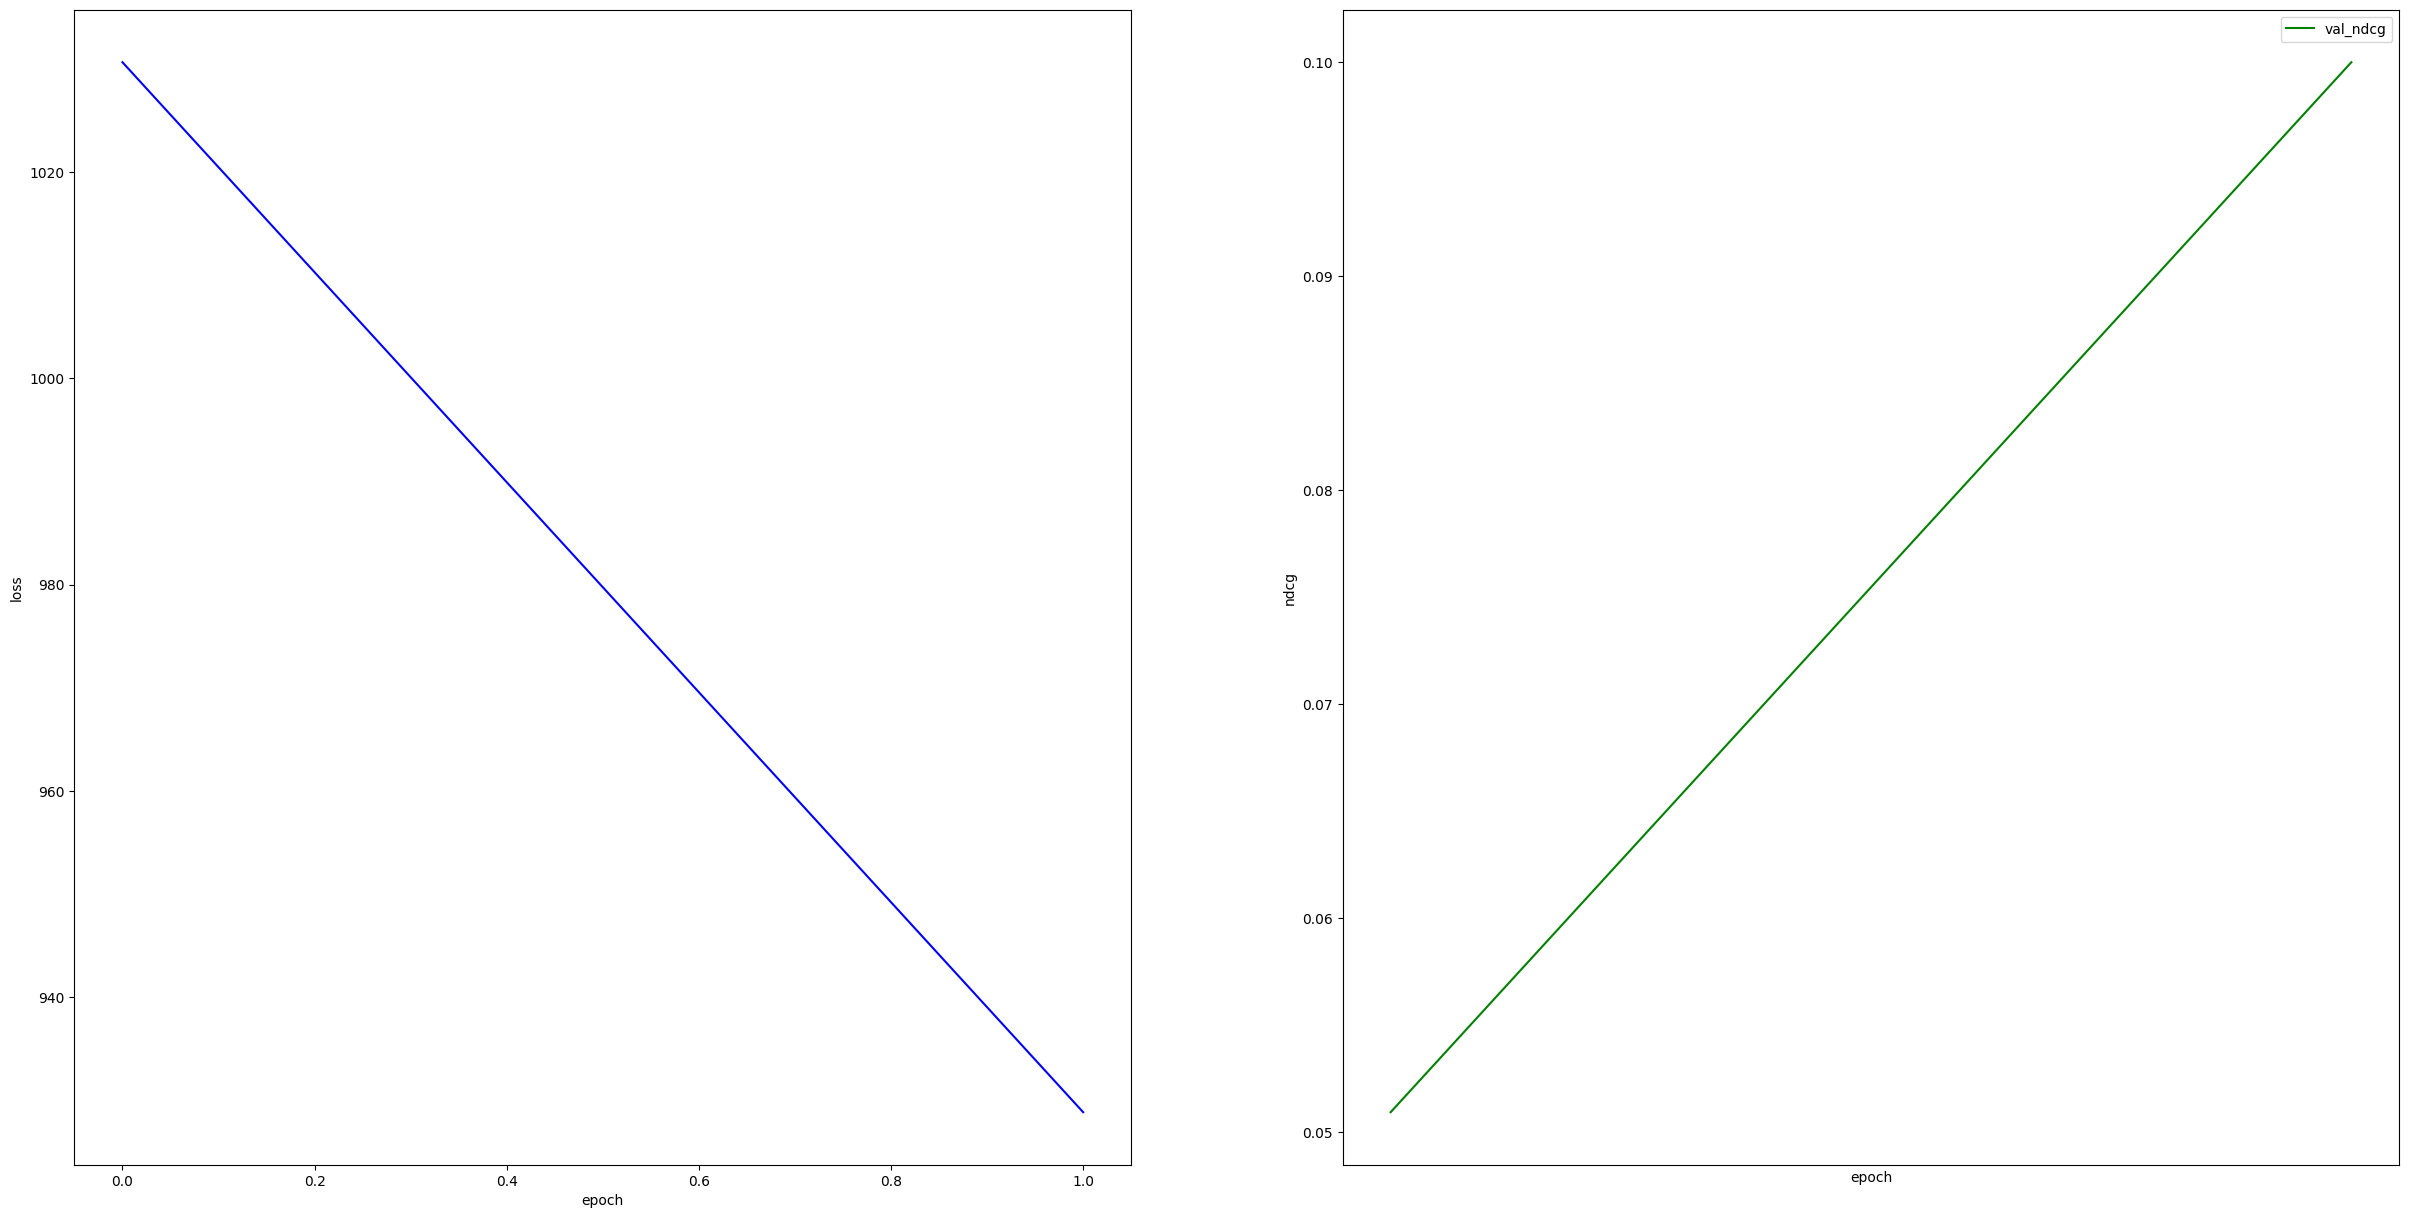

21-Oct-24 10:11:59, replay, INFO: ndcg val =0.1000
100%|██████████| 1139/1139 [02:39<00:00,  7.13it/s]                             


+--------+--------+------------------+
|user_idx|item_idx|         relevance|
+--------+--------+------------------+
|      18|    1870|5.3775389406503695|
|      18|      47| 4.739410579565877|
|      18|     395| 4.541020278328126|
|      18|     161|4.4218457112952425|
|      18|    3868| 4.158440323365729|
|      18|     507| 4.064827943320855|
|      18|      48| 3.883049547540212|
|      18|     633|3.8444350236367693|
|      18|     943|3.8056227200041017|
|      18|    1056| 3.797194694917845|
|     186|      12| 6.420963270877239|
|     186|     194| 5.656853085045034|
|     186|     391| 5.453808038494393|
|     186|      49| 5.335534083911569|
|     186|     104|  4.99959438502184|
|     186|      43| 4.954802449673658|
|     186|      40|4.8434793129332245|
|     186|     172| 4.813935521652629|
|     186|     145|4.7580761479426545|
|     186|      15| 4.704732956025126|
|     471|       2| 5.780186942677461|
|     471|      17| 5.615563203759828|
|     471|      56| 5.497

            NDCG@10    MRR@10  Coverage@10    fit_time
Neural TS  0.199511  0.361554     0.038777  704.733167
CPU times: user 1h 33min 34s, sys: 3min 5s, total: 1h 36min 39s
Wall time: 26min 26s


In [49]:
%%time
pred = full_pipeline(bandit_models, e, train, test)

In [50]:
e.results.sort_values('NDCG@10', ascending=False)

,MAP@10,NDCG@10,HitRate@1,HitRate@5,HitRate@10,Coverage@10,Surprisal@10,MRR@10,fit_time,predict_time,metric_time,full_time,params
Neural TS,0.115842,0.199511,0.246708,0.51712,0.623354,0.038777,0.16458,0.361554,704.733167,545.179961,336.674005,1586.587133,"{'n_epochs': 2, 'union_cols': {'continuous_col..."
